### This Notebook is an attempt to create a GUI.
#### It was used to create, refine and debug the prototype for the MLD GUI.  
**I am going to be sincere and say that this work is all sweat and tears from Chat GPT**



In [1]:
## ideas to incorporate!
## ctrl z button
## a next button: you load a file with a number of profiles in it and then you can flick through them one by one 


In [2]:
#pip install mpldatacursor

In [3]:
import tkinter as tk
from tkinter import filedialog
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import numpy as np

In [4]:
# Generate dummy data for temperature profiles
num_profiles = 2
depth = np.arange(0, 1000, 10)  # Depth in meters
temperature_profiles = []
for _ in range(num_profiles):
    temperature = np.random.uniform(2, 20, len(depth))  # Temperature in °C
    temperature_profiles.append((depth, temperature))


In [5]:
temperature_profiles,2



([(array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
          130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250,
          260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380,
          390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490, 500, 510,
          520, 530, 540, 550, 560, 570, 580, 590, 600, 610, 620, 630, 640,
          650, 660, 670, 680, 690, 700, 710, 720, 730, 740, 750, 760, 770,
          780, 790, 800, 810, 820, 830, 840, 850, 860, 870, 880, 890, 900,
          910, 920, 930, 940, 950, 960, 970, 980, 990]),
   array([ 9.91579488, 15.4572485 , 12.99732068,  5.25049002, 19.05095186,
          18.14580521, 10.08111348, 13.24574237,  7.05615789, 11.75557332,
           7.57042875, 16.52344488, 15.92000009, 13.84404227, 12.91214489,
           8.43214414, 14.03557062, 17.94396028, 18.60822276,  3.45675913,
           3.70729293, 13.55565781,  8.98779581, 15.4283792 ,  8.22344261,
          17.47883604,  7.86823305,  8.6974

MLD Recorded Depths: []


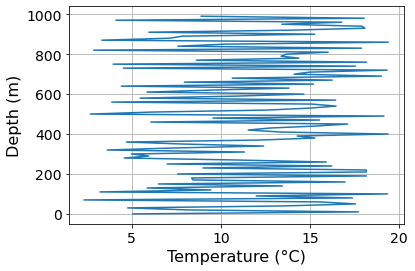

In [8]:
fontsize=16

class OceanProfileGUI:
    def __init__(self, root, temperature_profiles):
        self.root = root
        self.root.title("Mixed Layer Depth Analysis Software")

        self.temperature_profiles = temperature_profiles
        self.num_profiles = len(temperature_profiles)
        self.current_profile_index = 0  # Index of the currently displayed profile

        self.canvas = plt.figure(figsize=(6, 4))
        self.plot_area = self.canvas.add_subplot(111)
        self.plot_area.set_xlabel("Temperature (°C)", fontsize=fontsize)
        self.plot_area.set_ylabel("Depth (m)", fontsize=fontsize)
        # Set font size for tick labels
        self.plot_area.tick_params(axis='both', which='major', labelsize=14)

        depth, temperature = temperature_profiles[self.current_profile_index]
        self.plot_area.plot(temperature, depth)
        self.plot_area.grid(True)  # Enable grid lines
        self.canvas_widget = FigureCanvasTkAgg(self.canvas, master=root)
        self.canvas_widget.get_tk_widget().pack(side=tk.LEFT, fill=tk.BOTH, expand=True)  # Fill window and expand to fit

        self.selected_depth = None
        self.recorded_depths = []  # List to store recorded depths

        # Create a side box to display profile index and depth
        self.side_box = tk.Text(root, height=10, width=20)
        self.side_box.pack(side=tk.RIGHT)

        # Connect event handlers
        self.canvas_widget.mpl_connect('motion_notify_event', self.on_hover_profile)
        self.canvas_widget.mpl_connect('button_press_event', self.on_click_profile)

        self.update_side_box()  # Update the side box with current profile index

        self.next_button = tk.Button(root, text="Next", command=self.load_next_profile)
        self.next_button.pack()

        # Store the reference to the red dashed line
        self.red_line = None

    def load_next_profile(self):
        # Record the last clicked depth if available before moving to the next profile
        if self.selected_depth is not None:
            self.recorded_depths.append(self.selected_depth)

        # Load and plot the next profile if not all profiles have been displayed
        if self.current_profile_index < self.num_profiles - 1:
            self.current_profile_index += 1
            self.plot_area.clear()
            depth, temperature = self.temperature_profiles[self.current_profile_index]
            self.plot_area.plot(temperature, depth)
            self.plot_area.grid(True)  # Enable grid lines
            self.selected_depth = None  # Reset selected depth for the new profile

            # Reset reference to red dashed line
            self.red_line = None

            self.update_side_box()  # Update the side box with current profile index
            self.canvas_widget.draw()
        else:
            # Close the GUI if all profiles have been displayed
            self.root.quit()
            self.root.destroy()

    def on_hover_profile(self, event):
        # Display depth in side box as you hover over the profile
        if event.xdata is not None and event.ydata is not None:
            depth = event.ydata
            self.update_side_box(hover_depth=depth)  # Update the side box with current profile index and hover depth

            # Get the current plot size
            canvas_width, canvas_height = self.canvas_widget.get_tk_widget().winfo_width(), self.canvas_widget.get_tk_widget().winfo_height()

            # Calculate the position of the red dashed line based on the plot size
            x_left, x_right = self.plot_area.get_xlim()
            y_bottom, y_top = self.plot_area.get_ylim()
            x_data = (event.x - 70) / canvas_width * (x_right - x_left) + x_left  # Adjust x-coordinate for padding
            y_data = event.y / canvas_height * (y_top - y_bottom) + y_bottom

            # Draw red horizontal dashed line following cursor
            if self.red_line is not None:
                self.red_line.set_ydata(y_data)
            else:
                self.red_line = self.plot_area.axhline(y_data, color='r', linestyle='--')

            self.canvas_widget.draw()

    def on_click_profile(self, event):
        # Record depth when clicking on profile
        if event.xdata is not None and event.ydata is not None:
            self.selected_depth = event.ydata
            self.update_side_box()  # Update the side box with current profile index and MLD

    def update_side_box(self, hover_depth=None):
        # Update the side box with current profile index and depth
        self.side_box.delete(1.0, tk.END)  # Clear previous content
        self.side_box.insert(tk.END, f"Profile: {self.current_profile_index + 1}/{self.num_profiles}\n")
        if self.selected_depth is not None:
            self.side_box.insert(tk.END, f"MLD Depth: {self.selected_depth:.2f} m\n")
        if hover_depth is not None:
            self.side_box.insert(tk.END, f"Depth: {hover_depth:.2f} m\n")

if __name__ == "__main__":
    # Assuming temperature_profiles is the variable containing the loaded profiles

    # Create the GUI
    root = tk.Tk()
    gui = OceanProfileGUI(root, temperature_profiles)
    root.mainloop()

    # Output recorded depths
    print("MLD Recorded Depths:", gui.recorded_depths)

## A trial for a new plot that adds salinity and density plots 

In [6]:
# Generate dummy data for salinity profiles
num_profiles = 2
depth = np.arange(0, 1000, 10)  # Depth in meters
salinity_profiles = []
for _ in range(num_profiles):
    salinity = np.random.uniform(28, 35, len(depth))  
    salinity_profiles.append((depth, salinity))

In [7]:
# Generate dummy data for salinity profiles
num_profiles = 2
depth = np.arange(0, 1000, 10)  # Depth in meters
density_profiles = []
for _ in range(num_profiles):
    density = np.random.uniform(1012, 1027, len(depth))  
    density_profiles.append((depth, density))

MLD Recorded Depths: [436.9021339220015, 383.2474858964925]


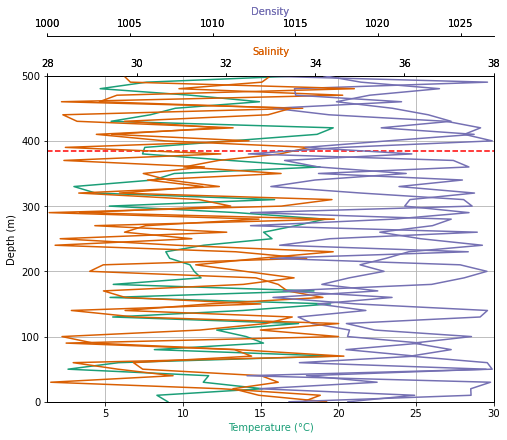

In [22]:
import tkinter as tk
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

class OceanProfileGUI:
    def __init__(self, root, temperature_profiles, salinity_profiles, density_profiles,tmin=2,tmax=30,smin=28,smax=38,dmin=1000,dmax=1027,pmin=0,pmax=500):
        self.root = root
        self.root.title("Ocean Profile Analysis")

        self.temperature_profiles = temperature_profiles
        self.salinity_profiles = salinity_profiles
        self.density_profiles = density_profiles
        self.tmin = tmin
        self.tmax = tmax
        self.smin = smin
        self.smax = smax
        self.dmin = dmin
        self.dmax = dmax
        self.pmin = pmin
        self.pmax = pmax
        self.num_profiles = len(temperature_profiles)
        self.current_profile_index = 0  # Index of the currently displayed profile
        
        # Create a figure with one subplot
        self.fig, self.plot_area = plt.subplots(figsize=(8, 6))

        self.update_profiles()  # Initial plot update

        self.canvas_widget = FigureCanvasTkAgg(self.fig, master=root)
        self.canvas_widget.get_tk_widget().pack(side=tk.LEFT, fill=tk.BOTH, expand=True)  # Fill window and expand to fit

        self.selected_depth = None
        self.recorded_depths = []  # List to store recorded depths

        # Create a side box to display profile index and depth
        self.side_box = tk.Text(root, height=10, width=20)
        self.side_box.pack(side=tk.RIGHT)

        # Connect event handlers
        self.canvas_widget.mpl_connect('motion_notify_event', self.on_hover_profile)
        self.canvas_widget.mpl_connect('button_press_event', self.on_click_profile)

        self.update_side_box()  # Update the side box with current profile index

        self.next_button = tk.Button(root, text="Next", command=self.load_next_profile)
        self.next_button.pack()

        # Store the reference to the red dashed line
        self.red_lines = []

    def update_profiles(self):
        self.plot_area.clear()

        # Plot temperature data
        depth, temperature = self.temperature_profiles[self.current_profile_index]
        temperature_plot = self.plot_area.plot(temperature, depth, label='Temperature (°C)', color=(27/255, 158/255, 119/255))
        self.plot_area.set_xlabel("Temperature (°C)")
        self.plot_area.set_ylabel("Depth (m)")

        # Plot salinity data on secondary y-axis
        depth, salinity = self.salinity_profiles[self.current_profile_index]
        salinity_axis = self.plot_area.twiny()
        salinity_axis.plot(salinity, depth, label='Salinity', color=(217/255,95/255,2/255))
        salinity_axis.set_xlabel("Salinity", color=(217/255,95/255,2/255))
        salinity_axis.set_xlim(smin, smax) 
       
        # Plot density data on secondary y-axis, slightly higher than salinity axis
        depth, density = self.density_profiles[self.current_profile_index]
        density_axis = self.plot_area.twiny()
        density_axis.plot(density, depth, label='Density', color=(117/255,112/255,179/255))
        density_axis.set_xlabel("Density", color=(117/255,112/255,179/255))
        density_axis.spines['top'].set_position(('outward', 40))  # Adjust the position of the density axis
        density_axis.set_xlim(dmin, dmax) 
        
        # Set temperature x-axis label color to match temperature plot
        temperature_xaxis = self.plot_area.xaxis
        temperature_xaxis.label.set_color(temperature_plot[0].get_color())
        temperature_xaxis.set_view_interval(tmin, tmax)   
        
        # Set limits for y-axis
        self.plot_area.set_ylim(pmin, pmax)  
        
        # Combine the legends
#        self.plot_area.legend(loc='upper right')

        self.plot_area.grid(True)  # Add grid lines

    def load_next_profile(self):
        # Record the last clicked depth if available before moving to the next profile
        if self.selected_depth is not None:
            self.recorded_depths.append(self.selected_depth)

        # Load and plot the next profile if not all profiles have been displayed
        if self.current_profile_index < self.num_profiles - 1:
            self.current_profile_index += 1
            self.update_profiles()  # Update plot with new data
            self.update_side_box()  # Update the side box with current profile index
            self.remove_red_lines()  # Remove previous red lines
            self.canvas_widget.draw()
        else:
            # Close the GUI if all profiles have been displayed
            self.root.quit()
            self.root.destroy()

    def on_hover_profile(self, event):
        # Display depth in side box as you hover over the profile
        if event.xdata is not None and event.ydata is not None:
            depth = event.ydata
            self.update_side_box(hover_depth=depth)  # Update the side box with current profile index and hover depth

            # Draw red horizontal dashed line following cursor
            if self.red_lines:
                for red_line in self.red_lines:
                    red_line.set_ydata(depth)
            else:
                red_line = self.plot_area.axhline(depth, color='r', linestyle='--')
                self.red_lines.append(red_line)

            self.canvas_widget.draw()

    def on_click_profile(self, event):
        # Record depth when clicking on profile
        if event.xdata is not None and event.ydata is not None:
            self.selected_depth = event.ydata
            self.update_side_box()  # Update the side box with current profile index and MLD

    def update_side_box(self, hover_depth=None):
        # Update the side box with current profile index and depth
        self.side_box.delete(1.0, tk.END)  # Clear previous content
        self.side_box.insert(tk.END, f"Profile: {self.current_profile_index + 1}/{self.num_profiles}\n")
        if self.selected_depth is not None:
            self.side_box.insert(tk.END, f"MLD Depth: {self.selected_depth:.2f} m\n")
        if hover_depth is not None:
            self.side_box.insert(tk.END, f"Depth: {hover_depth:.2f} m\n")

    def remove_red_lines(self):
        for red_line in self.red_lines:
            red_line.remove()
        self.red_lines.clear()


if __name__ == "__main__":
    # Assuming temperature_profiles, salinity_profiles, and density_profiles are the variables containing the loaded profiles

    # Create the GUI
    root = tk.Tk()
    gui = OceanProfileGUI(root, temperature_profiles, salinity_profiles, density_profiles)
    root.mainloop()

    # Output recorded depths
    print("MLD Recorded Depths:", gui.recorded_depths)


In [ ]:
##